In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
import utils

import os

out_root = '../../out/KNN'
root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

The local outlier factor is based on a concept of a local density, where locality is given by $k$ nearest neighbors, whose distance is used to estimate the density.
By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors.
These lower density points are considered to be outliers. 

* $k-distance(A)$ is the distance of object $A$ from its k neighbor.
* $reachability-distance_{k}(A,B)=max(k-distance(B),d(A,B))$
* local reachability density $ldr_{k}(A) = 1/ \left( \frac{\sum_{B\in N_k(A)}reachability-distance_k(A,B)}{|N_k(A)}\right)$

<center> $LOF_k(A) = \frac{\sum_{B\in N_k(A) \frac{lrd(B)}{lrd(A)}}}{|N_k(A)|}$ </center>

Thus:
* $LOF < 1$ means Higher density than neighbors (inlier)
* $LOF > 1$ means Lower density than neighbors (outlier)


In this notebook, we will apply the LOF to the data on tiling windows of one hour, in order to compare the results with the Tukey Fence technique applied before.

In particular with this technique we consider both the timestamp and the value of the measurements to compute the distance between points, so in theory a point will be considered an outliers either the value of the measurement is abnormal, the timestamp is too far w.r.t the previous (or the successive) points or both.

One possible problem of aggregating over time window is that points at the 'edge' of the time windows are misclassified because the closest points are in the other window.
This behavior is a little mitigated keeping a fixed number of the last observation, that are used to compute the LOF, then only the points that has been already classified from the past time windows are simply ignored in the outliers count for the current time window.

The choice of the k is 1 because across different runs, is the one that give more reasonable results, in fact with k too high (> 3) it is not able to detect any outliers.

In [3]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import math

def KNN_slider(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    win_col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    win_ret = pd.DataFrame(columns = win_col)
    
    point_col = ['id', 'ts', 'val', 'is_in']
    point_ret = pd.DataFrame(columns = point_col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    prev_window = pd.DataFrame()
    
    root = 1
    model = LocalOutlierFactor(n_neighbors=root, algorithm='auto', metric = 'euclidean', contamination='auto', n_jobs=1)
    
    for start, end, window in gen:
        if len(window) == 0:
            continue
        
        if len(prev_window) + len(window) < expected_num_measurements:
            prev_window = prev_window.append(window)
        
        curr_data = prev_window.append(window) 
        to_fit = curr_data.iloc[:,1:3].values.reshape(-1,2)
        x = model.fit_predict(to_fit)
        
        n_out = 0
        n_in = 0
        # count outliers
        j = len(prev_window.values)
        for i in range(len(window)):
            frame = window.iloc[i,:]
            
            ts = frame[ts_index].astype('datetime64[ms]')
            value = frame[val_index]
            out = x[j]
            if out == -1:
                n_out += 1
            else:
                n_in += 1
            
            j+=1
            
            new_data = pd.DataFrame([[name, ts, value, out]], columns = point_col)
            point_ret = point_ret.append(new_data, sort = False)
            
            prev_window = prev_window.append(frame)
    
            prev_window = prev_window.iloc[1:,:]
        
        win_data = pd.DataFrame([[name, start, end, n_out, n_in, expected_num_measurements-n_in-n_out]], columns = win_col)
        win_ret = win_ret.append(win_data, sort = False)
            
        
    return win_ret, point_ret

In [4]:
if not os.path.isdir(out_root):
    os.mkdir(out_root)
    
res = []

In [5]:
def gen_plots(root, out_root, to_plot):
    
    path = os.path.join(root, to_plot)
    window_path = os.path.join(out_root, "win_" + to_plot)
    out_path = os.path.join(out_root, "out_" + to_plot)
    
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    try:
        y = pd.read_csv(window_path)
        y = y.astype({'start': 'datetime64[ms]', 'stop': 'datetime64[ms]'})
        x = pd.read_csv(out_path)
        x = x.astype({'ts': 'datetime64[ms]'})
    except Exception as e:
        print(e)
        y, x = KNN_slider(df)
        y.to_csv(window_path, index = None)
        x.to_csv(out_path, index= None)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax1 = ax[0]
    ax2 = ax[1]
    
    x.plot(ax = ax1, x = 1, y = [2], kind='line')
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[3]
        if boolean == -1:
            ax1.plot(ts, val, 'ro-')
    ax1.xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax2, kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax2.set_xlabel('window start time')
    ax2.set_ylabel('#number of measurements')
    ax2.xaxis_date()
    ax2.legend()
    ax2.grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
        
    return name, num_missed, num_out, num_in

As the previous case are produced two plots, one on the left the graph shoving the measurements, and the red dots are the outliers. 
On the tight a barplot showing the aggregation values on the time window With number of outliers, number of inliers and number of missing values. 

In this case the analysis will be done considering the sensor within the same node, and not on sensors of the same type.

## Node 0x3bd

This is the node with most missing values.

<IPython.core.display.Javascript object>


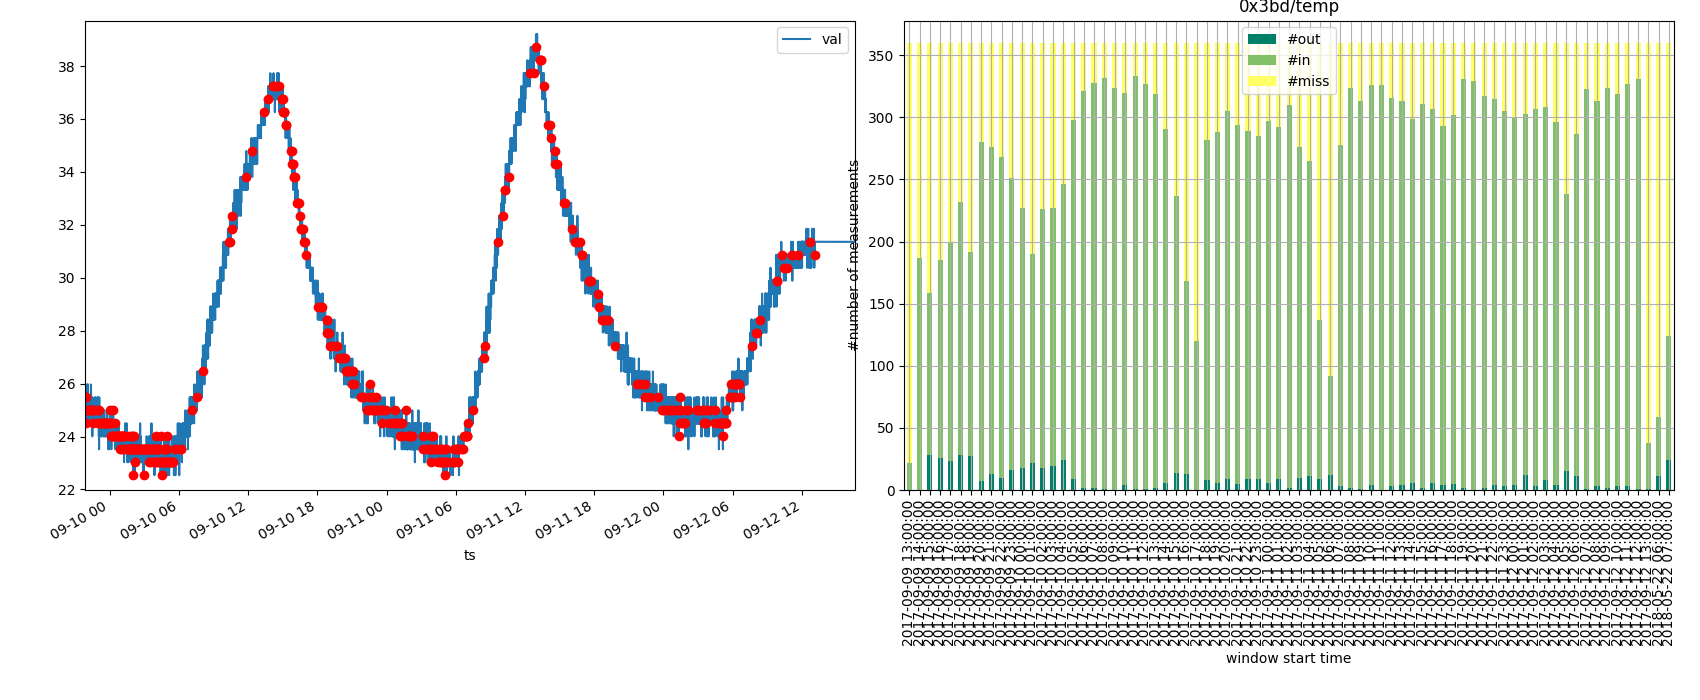

<IPython.core.display.Javascript object>


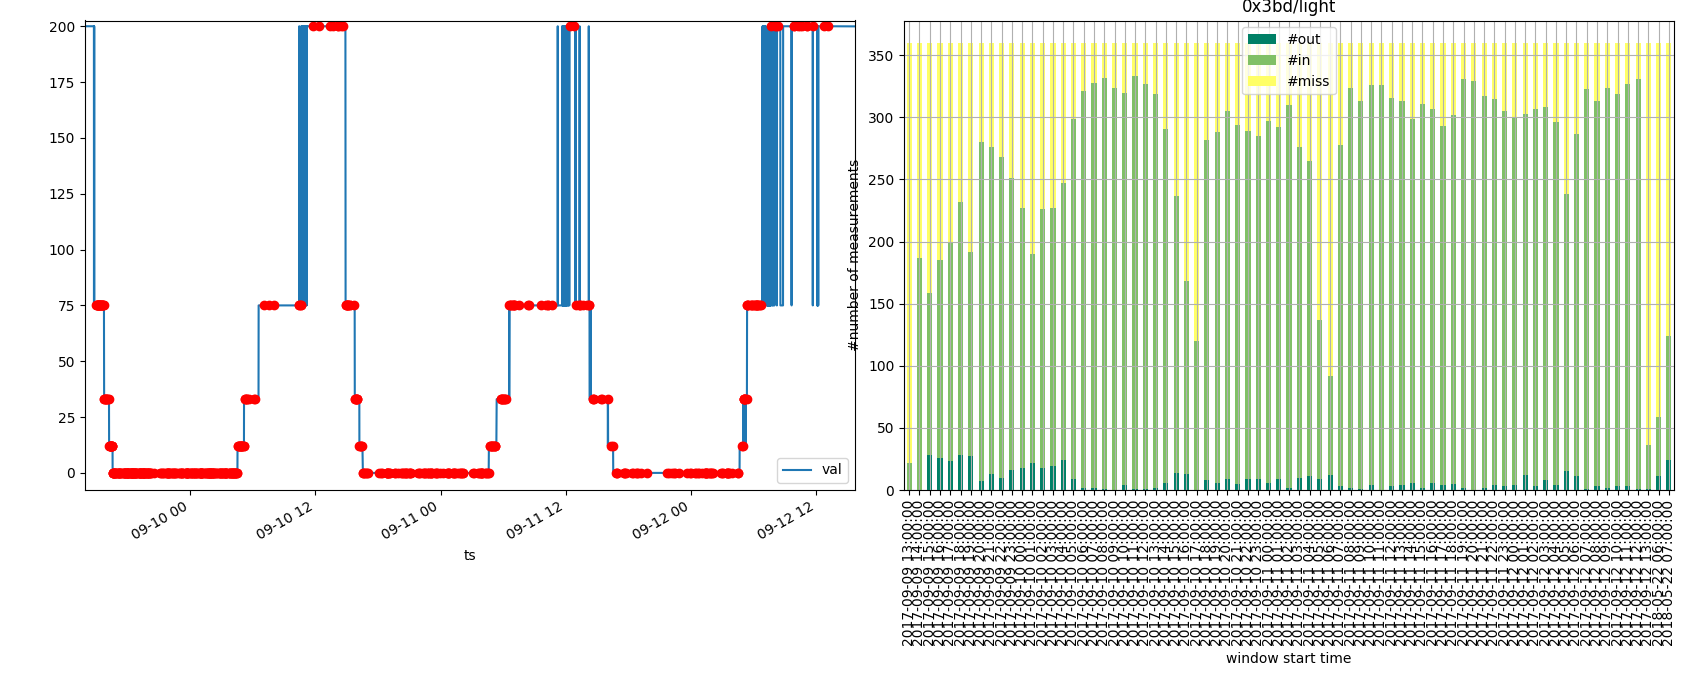

<IPython.core.display.Javascript object>


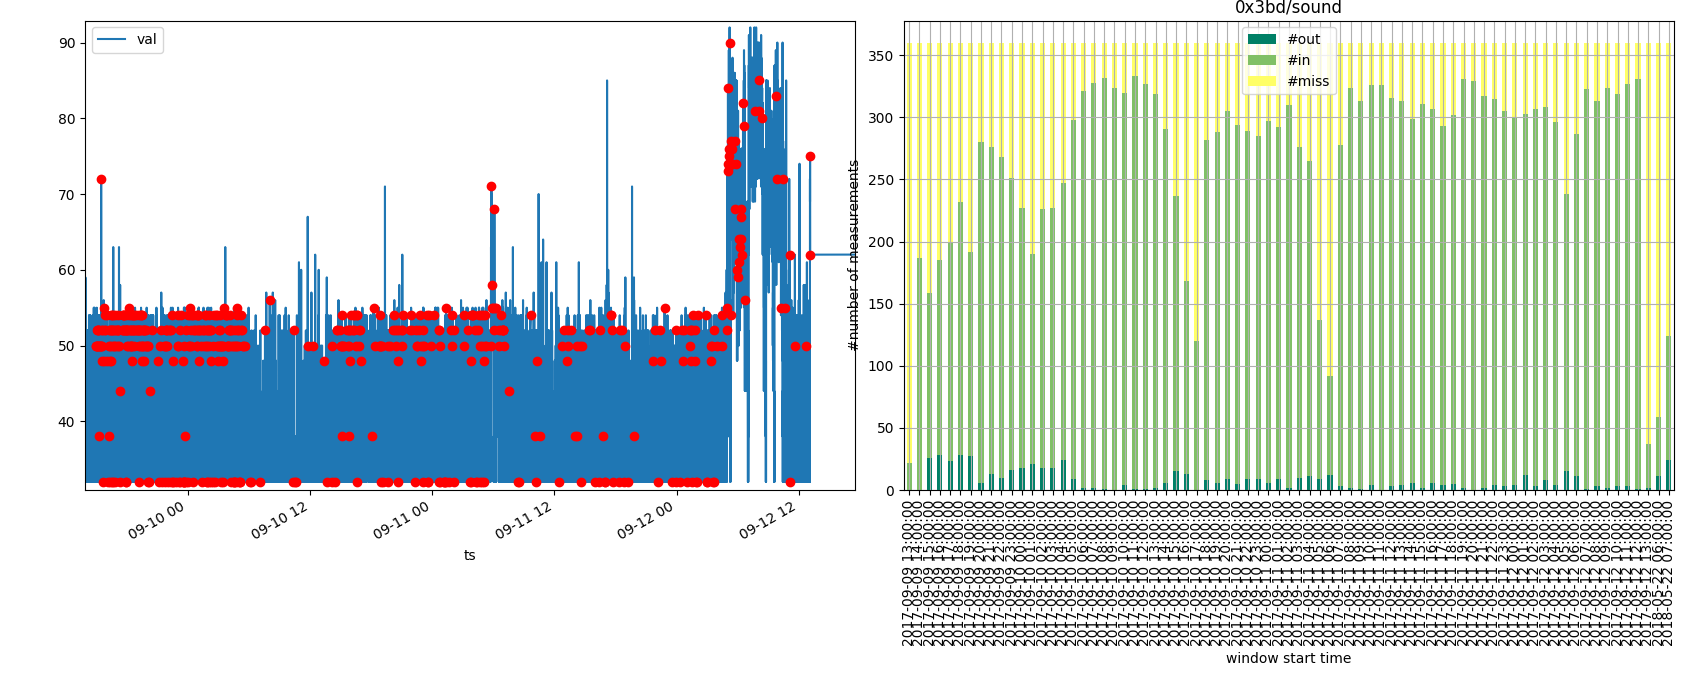

In [6]:
to_plot = [t_path[0], l_path[0], s_path[0]] 
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")
    plt.show()

On thing that can be noticed is that the number of outliers is similar between all the senors, even if the sensors are of different kind.

The fact that the number of outliers is almost the same is probably due by the fact that the algorithm gives more importance to the the component of the distance given by the time that the distance given by the values measured.

Naively we can plot the timestamps of outliers of all the sensor within the node and see if the outliers are detected in the same timestamp.

<IPython.core.display.Javascript object>


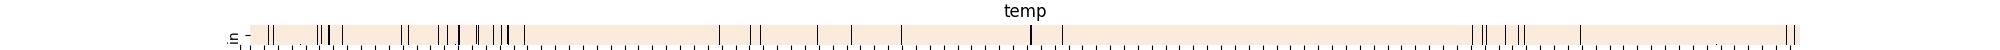

<IPython.core.display.Javascript object>


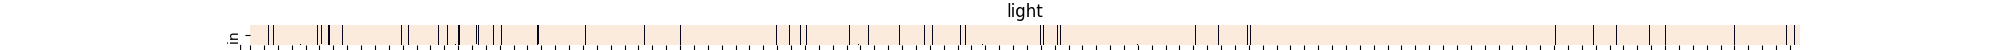

<IPython.core.display.Javascript object>


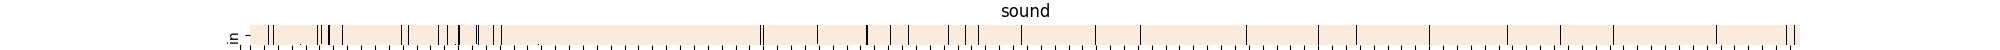

In [7]:
from seaborn import heatmap
for p in to_plot:
    out_path = os.path.join(out_root, "out_" + p)
    x = pd.read_csv(out_path)
    x = x.astype({'ts': 'datetime64[ms]'})
    node = x.iloc[0,0].split('/')[-2]
    name = x.iloc[0,0].split('/')[-1]
    x = x[['ts','is_in']]
    x = x.set_index(['ts'])
    fig = plt.figure(figsize=(20,0.5))
    fig.subplots_adjust(top=0.5)
    fig.tight_layout()
    ax = heatmap(x.transpose(), cbar = False)
    ax.set_title(name)
    plt.show()

This heatmap, has on the x axis the timestamp, while the lines marks the presence of outliers in the data.
As can be seen, only a part is common in the three sensors of the node, so the outliers found are not due only to the transmission delay.

The sensors are from top to bottom:
* temp
* light
* sound

## Node 0xfef

<IPython.core.display.Javascript object>


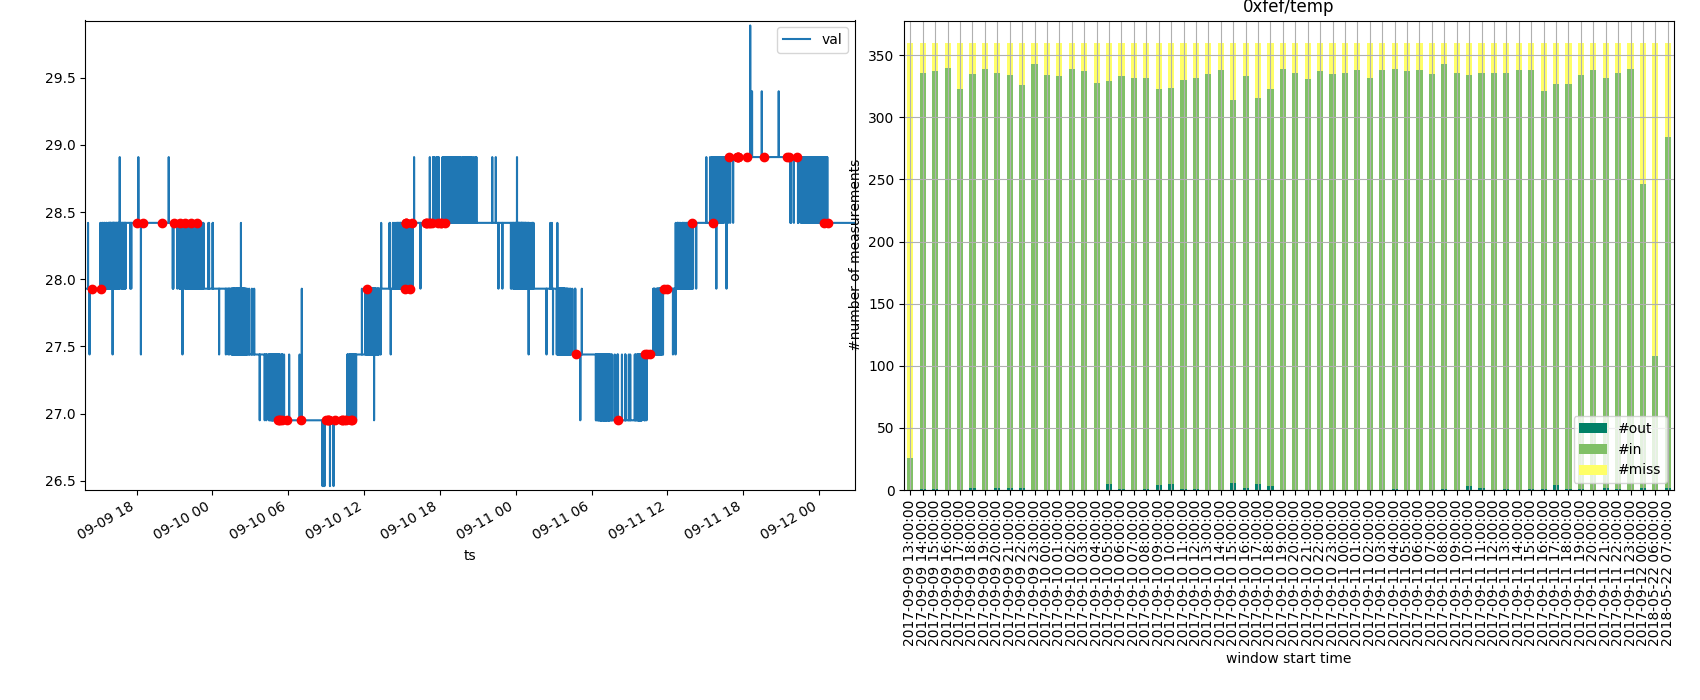

<IPython.core.display.Javascript object>


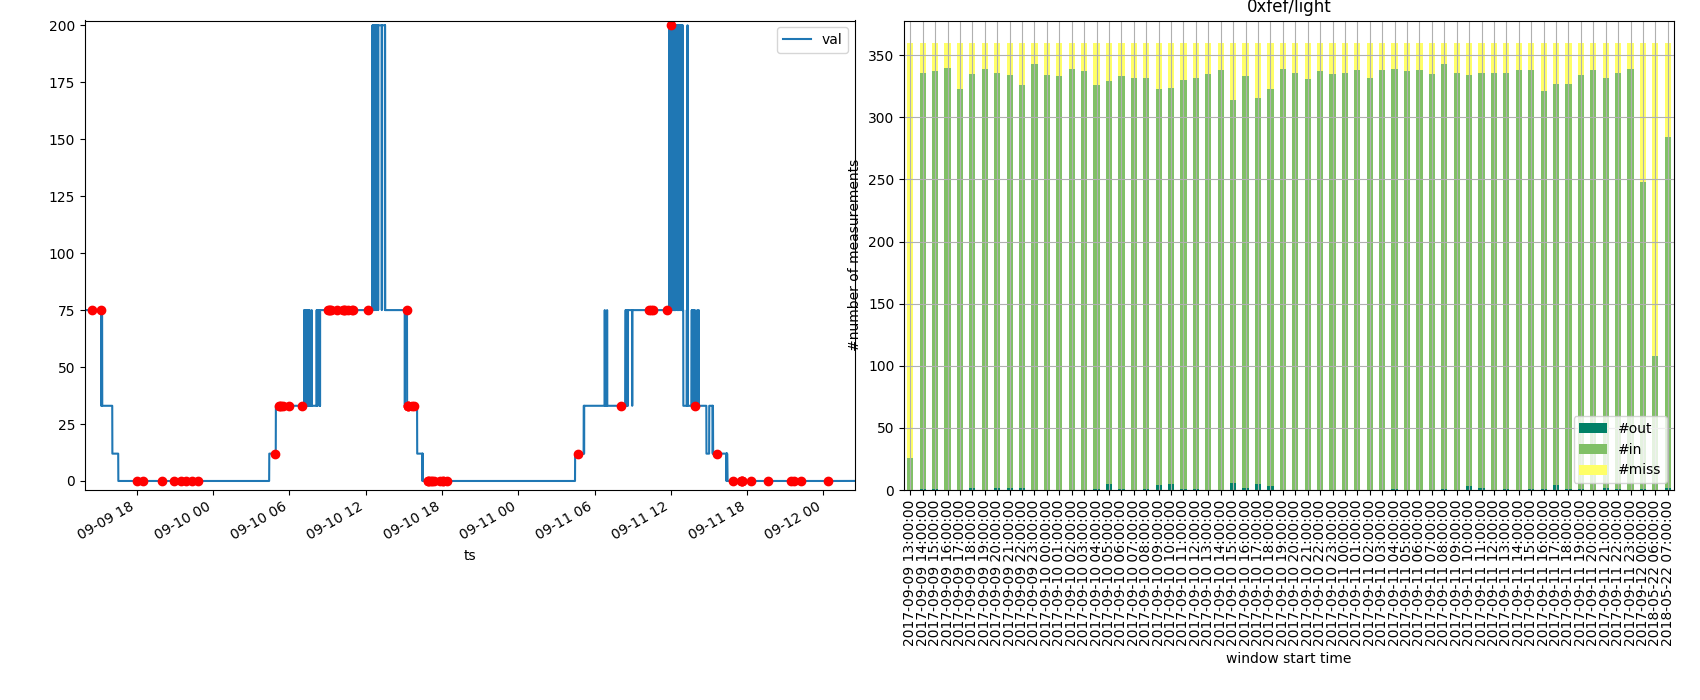

<IPython.core.display.Javascript object>


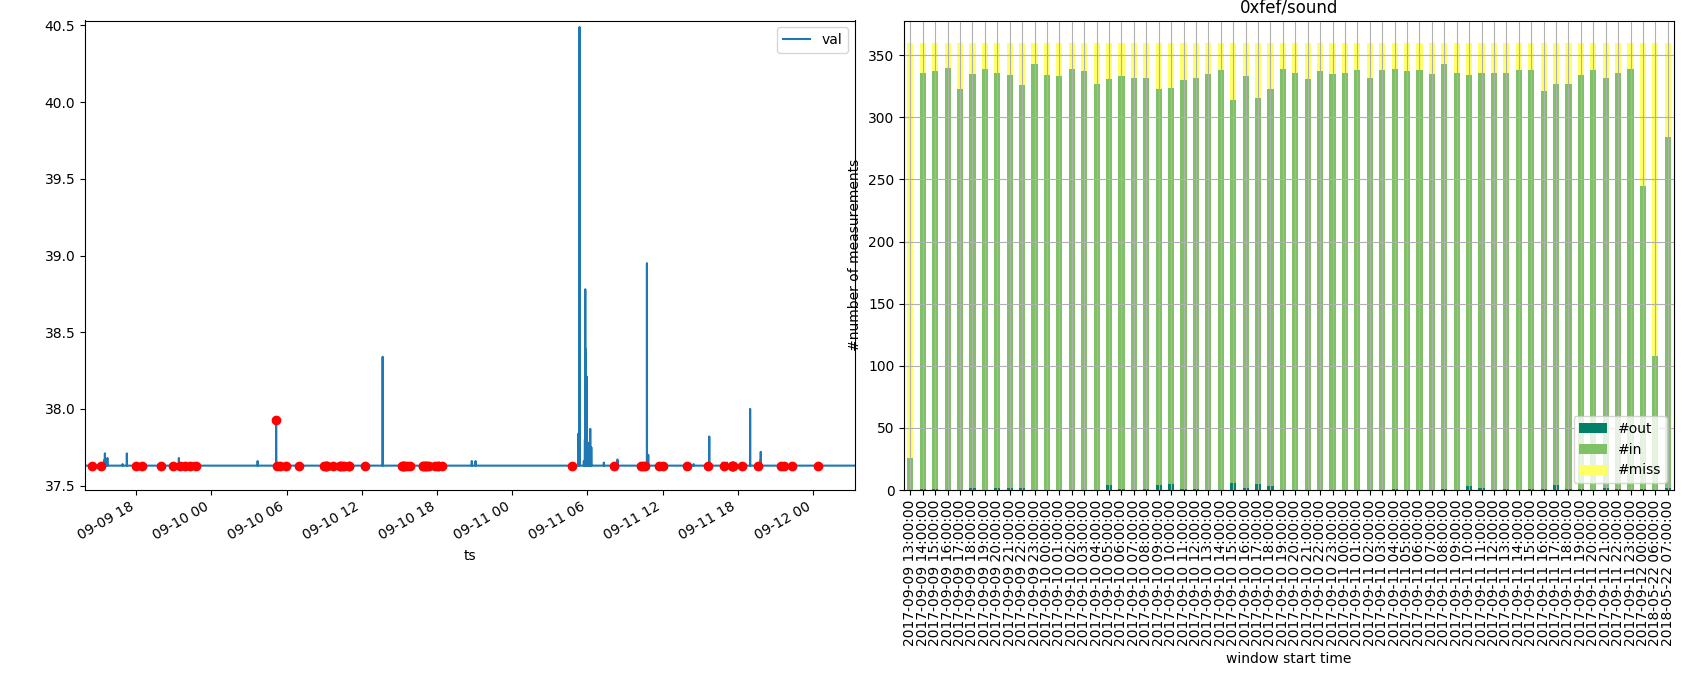

In [8]:
to_plot = [t_path[1], l_path[1], s_path[1]] 
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")
    plt.show()

<IPython.core.display.Javascript object>


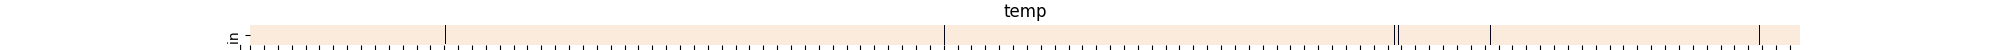

<IPython.core.display.Javascript object>


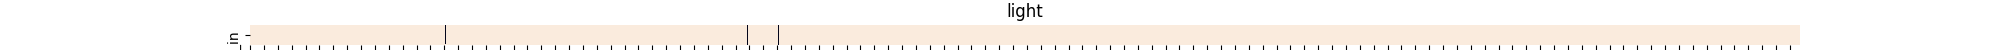

<IPython.core.display.Javascript object>


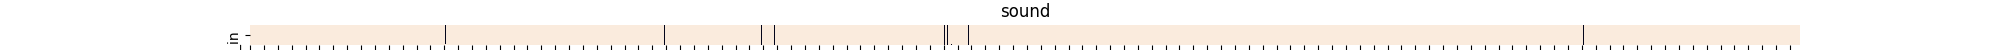

In [9]:
for p in to_plot:
    out_path = os.path.join(out_root, "out_" + p)
    x = pd.read_csv(out_path)
    x = x.astype({'ts': 'datetime64[ms]'})
    node = x.iloc[0,0].split('/')[-2]
    name = x.iloc[0,0].split('/')[-1]
    x = x[['ts','is_in']]
    x = x.set_index(['ts'])
    fig = plt.figure(figsize=(20,0.5))
    fig.subplots_adjust(top=0.5)
    fig.tight_layout()
    ax = heatmap(x.transpose(), cbar = False)
    ax.set_title(name)
    plt.show()

The sensors are from top to bottom:
* temp
* light
* sound

## Node 0xd19

<IPython.core.display.Javascript object>


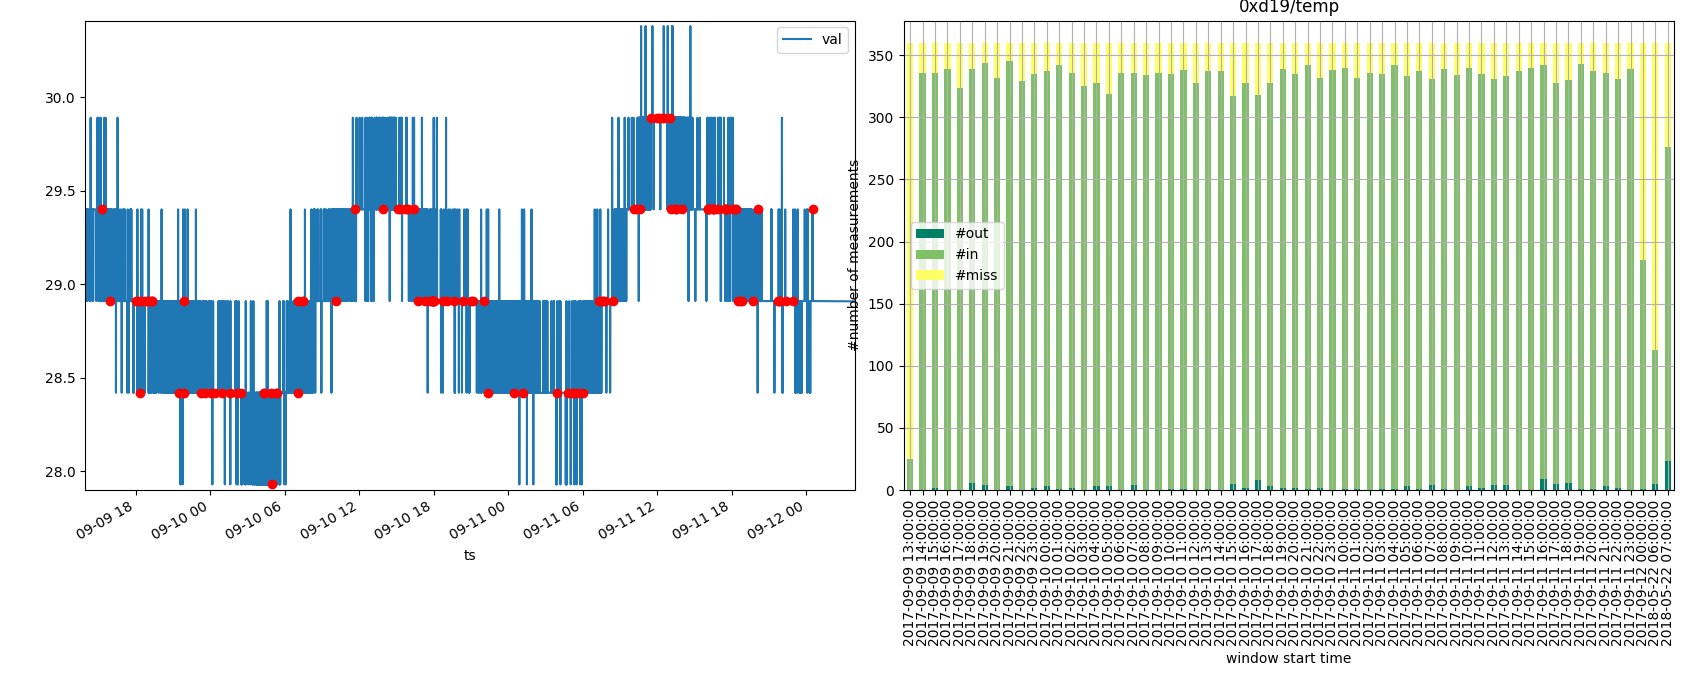

<IPython.core.display.Javascript object>


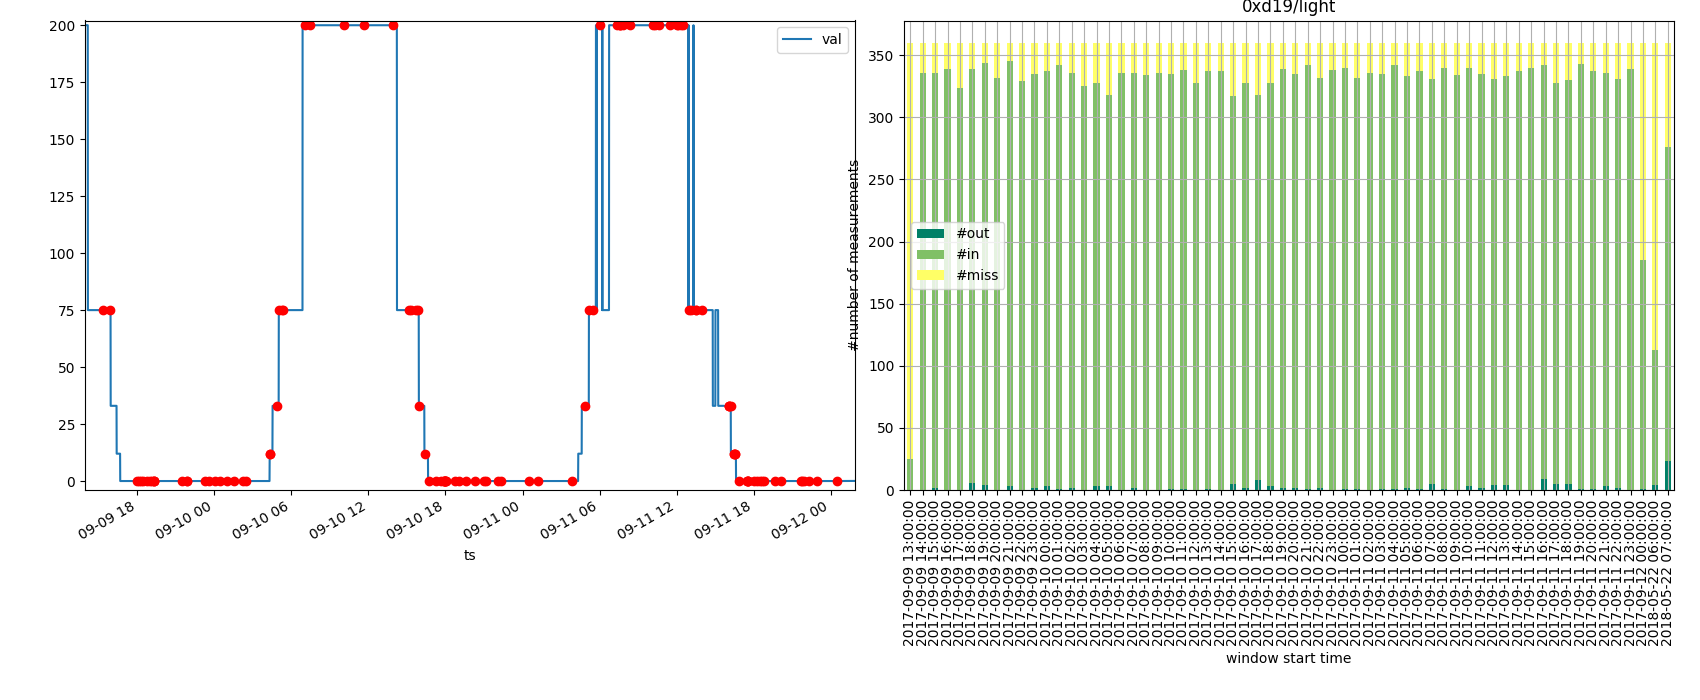

<IPython.core.display.Javascript object>


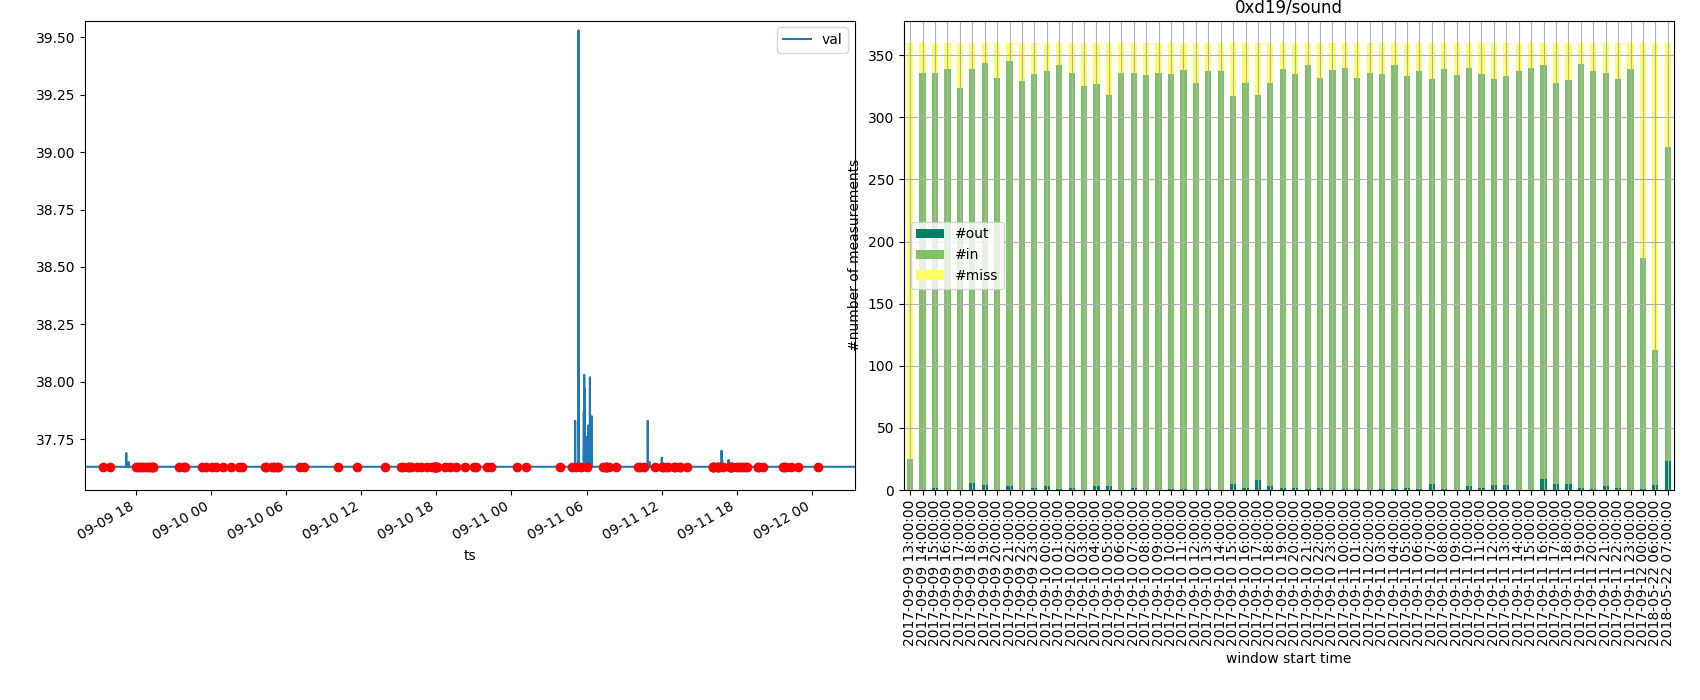

In [10]:
to_plot = [t_path[2], l_path[2], s_path[2]] 
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")
    plt.show()

<IPython.core.display.Javascript object>


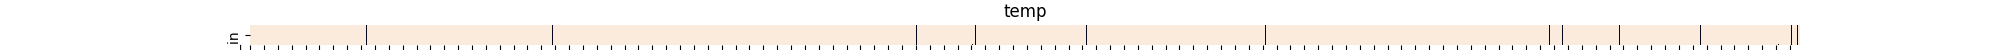

<IPython.core.display.Javascript object>


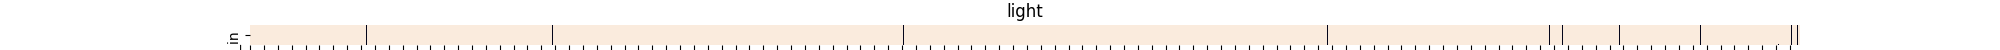

<IPython.core.display.Javascript object>


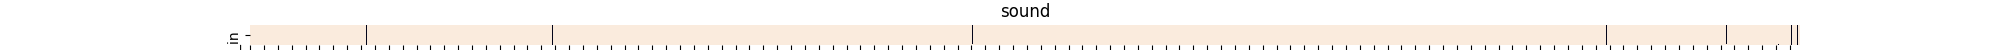

In [11]:
for p in to_plot:
    out_path = os.path.join(out_root, "out_" + p)
    x = pd.read_csv(out_path)
    x = x.astype({'ts': 'datetime64[ms]'})
    node = x.iloc[0,0].split('/')[-2]
    name = x.iloc[0,0].split('/')[-1]
    x = x[['ts','is_in']]
    x = x.set_index(['ts'])
    fig = plt.figure(figsize=(20,0.5))
    fig.subplots_adjust(top=0.5)
    fig.tight_layout()
    ax = heatmap(x.transpose(), cbar = False)
    ax.set_title(name)
    plt.show()

The sensors are from top to bottom:
* temp
* light
* sound

## Results on 1 hour aggregation
|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|596|19404|7000|2.98|
|0x3bd/light|596|19404|7000|2.98|
|0x3bd/sound|595|19405|7000|2.975|
|0xfef/temp|67|19933|2320|0.335|
|0xfef/light|67|19933|2320|0.335|
|0xfef/sound|65|19935|2320|0.325|
|0xd19/temp|143|19857|2320|0.715|
|0xd19/light|139|19861|2320|0.695|
|0xd19/sound|140|19860|2320|0.7|

Besides the nod 0x3bd, the other nodes are not commented since they show the same behavior of the first one.
The mainly difference is given by the number of missing values, and in particular in the node 0x3bd the number of outliers is bigger.

## Results without aggregation

This plot shows the number of outliers without the one hour aggregation.
In theory the result should be more clear since we can consider the density over all the points in the dataset to correctly classify the measurements.

Here we will produce only the heatmaps of the outliers above the whole period covered by the data.
This plots can be easily compared to the heatmaps produced in the one hour aggregation in order to see where the outliers found are different.

<IPython.core.display.Javascript object>


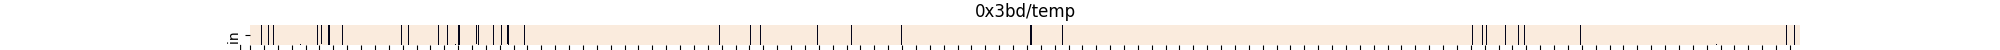

<IPython.core.display.Javascript object>


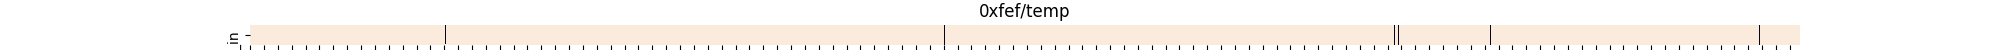

<IPython.core.display.Javascript object>


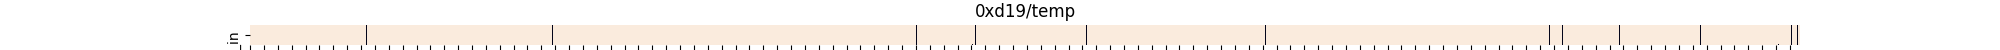

<IPython.core.display.Javascript object>


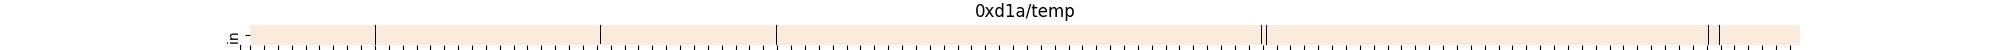

<IPython.core.display.Javascript object>


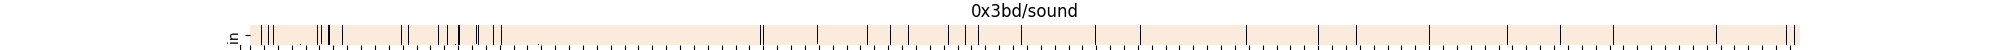

<IPython.core.display.Javascript object>


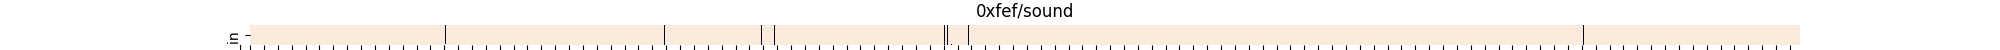

<IPython.core.display.Javascript object>


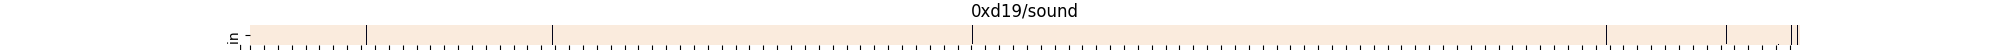

<IPython.core.display.Javascript object>


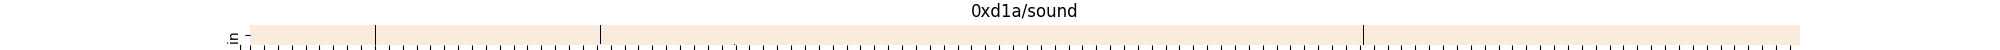

<IPython.core.display.Javascript object>


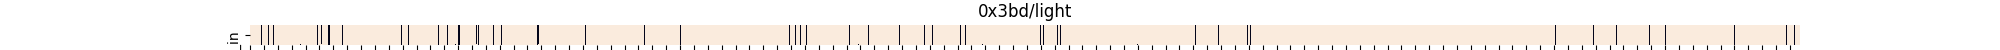

<IPython.core.display.Javascript object>


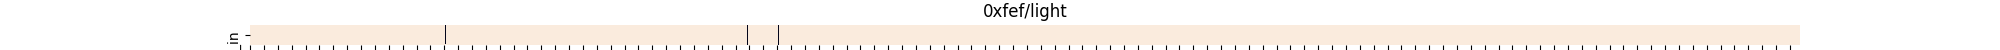

<IPython.core.display.Javascript object>


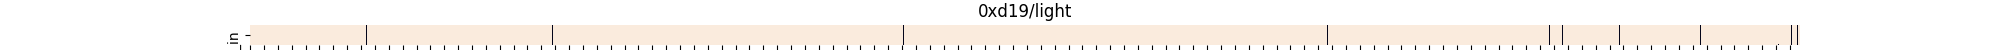

In [14]:
res_tot = []

def plot_on_df(root, to_plot, ax, k = 1):
    model = LocalOutlierFactor(n_neighbors = k, metric = 'euclidean', contamination = 'auto', n_jobs = 8) 
    path = os.path.join(root, to_plot)
    df = pd.read_csv(path, header = None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    samples = df.iloc[:,1:3].values
    out = model.fit_predict(samples)

    to_df = []

    for x, y in zip(samples,out):
        ts = x[0].astype('datetime64[ms]')
        val = x[1]
        to_df.append([ts, val, y])
    
    df = pd.DataFrame(to_df, columns = ['ts', 'value', 'is_in'])
    n_out = len(df[df['is_in'] == -1])
    n_in = len(df[df['is_in'] == 1])
    
    df = df[['ts','is_in']]
    df = df.set_index('ts')
    
    
    heatmap(df.transpose(), cbar = False, ax = ax)
    ax.set_title(name)
    plt.show()
    
    return name, n_out, n_in

to_plot = t_path + s_path + l_path

for p in to_plot:
    fig, ax = plt.subplots(figsize=(20,0.5))
    fig.subplots_adjust(top=0.5)
    name, n_out, n_in = plot_on_df(root, p, ax)
    res_tot.append("|" + str(name) + "|" + str(n_out) + "|" + str(n_in) + "|"  + str(n_out*100/(n_out+n_in)) + "|")

|sensor|#outliers|#inliers|%outliers|
|---|---|---|---|
|0x3bd/temp|626|19374|3.13|
|0xfef/temp|65|19935|0.325|
|0xd19/temp|142|19858|0.71|
|0xd1a/temp|53|19947|0.265|
|0x3bd/sound|625|19375|3.125|
|0xfef/sound|63|19937|0.315|
|0xd19/sound|140|19860|0.7|
|0xd1a/sound|53|19947|0.265|
|0x3bd/light|626|19374|3.13|
|0xfef/light|65|19935|0.325|
|0xd19/light|138|19862|0.69|

The number of outliers is more or less the same between the two runs.
Looking at the heatmaps, we can also say that the outliers are in the same positions.  